In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows',None)
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px

In [2]:
df=pd.read_csv("Final_invoice.csv")
df = df.rename(columns={'Total Amt Wtd Tax.':'Total_Expense'})

In [100]:
df.head(2)

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,477.0,2014,12
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,19.0,2015,1


In [101]:
import pgeocode
nomi = pgeocode.Nominatim('IN')


In [123]:
df["City"]=nomi.query_postal_code(np.array(df["Pin code"].astype(str))).county_name
# Data_Finalinvoice["updated_District"]=nomi.query_postal_code(np.array(Data_Finalinvoice["Pin code"].astype(str))).state_name
# Data_Finalinvoice["updated_Location_Area"]=nomi.query_postal_code(np.array(Data_Finalinvoice["Pin code"].astype(str))).place_name

In [124]:
df["Invoice_DateTime"]=df["Invoice Date"]+' '+df["Invoice Time"]
df["JobCard_DateTime"]=df["JobCard Date"]+' '+df["JobCard Time"]
df['JobCard_DateTime'] = pd.to_datetime(df['JobCard_DateTime'],dayfirst=True)
df['Invoice_DateTime'] = pd.to_datetime(df['Invoice_DateTime'],dayfirst=True)
df["Service_Time"]=df["Invoice_DateTime"]-df["JobCard_DateTime"]

In [125]:
df["Invoice_DateTime"] = pd.to_datetime(df["Invoice_DateTime"])
df["JobCard_DateTime"] = pd.to_datetime(df["JobCard_DateTime"])
df['Job_duration(in hrs)']=(df['Invoice_DateTime'] -df['JobCard_DateTime']).astype('timedelta64[h]')

In [126]:
df["Year"] = pd.DatetimeIndex(df["JobCard_DateTime"]).year

In [127]:
df["month"] = pd.DatetimeIndex(df["JobCard_DateTime"]).month

In [128]:
df.head()

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month,City
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,477.0,2014,12,Thane
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,19.0,2015,1,Thane
2,2,0.0,0.0,THANE,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,81055,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200004,11:12:57,173889,2015-01-02,11:40:44,33985,180.19,MARUTI SUZUKI,0.00,ZEN,7.005200e+09,0.00,Running Repairs,0.0,52.95,400607,BC01,THANE,NaN,NO,0.0,AP09AX0582,0.0,0.0,0.0,0.0,NaN,0.0,IMRAN,233.14,0.0,0.0,0.0,0.0,233.14,BC01SA2,2015-01-03 11:12:57,2015-01-02 11:40:44,0 days 23:32:13,23.0,2015,1,Thane
3,3,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200005,11:40:44,174158,2015-01-03,10:12:32,78584,0.00,TATA MOTORS,0.00,INDICA,7.005200e+09,0.00,SMC Redemption,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,0.00,0.0,0.0,0.0,0.0,0.00,BC01SA2,2015-01-03 11:40:44,2015-01-03 10:12:32,0 days 01:28:12,1.0,2015,1,Thane
4,4,0.0,0.0,THANE,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,18980,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200006,12:07:17,173860,2015-01-02,10:45:42,50057,1202.97,HYUNDAI,100.00,SANTRO XING,7.005200e+09,499.99,Paid Service,0.0,944.16,400603,BC01,THANE,NaN,NO,0.0,MH04CD9768,0.0,0.0,0.0,0.0,NaN,0.0,DAYANAND,2747.12,0.0,0.0,0.0,0.0,2747.12,BC01SA2,2015-01-03 12:07:17,2015-01-02 10:45:42,1 days 01:21:35,25.0,2015,1,Thane


In [129]:
df[df['Job_duration(in hrs)']<0]

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month,City


In [130]:
# df.drop(index=359015,axis=0,inplace=True)

In [131]:
df.Year.value_counts()

2016    196155
2015    125393
2014     95777
2013     56240
2012     18748
Name: Year, dtype: int64

In [132]:
# df.columns

In [133]:
df.shape

(492313, 66)

In [134]:
len(df['Customer No.'].unique())

253484

In [135]:
df.Year.value_counts()

2016    196155
2015    125393
2014     95777
2013     56240
2012     18748
Name: Year, dtype: int64

In [136]:
year_16=df[df["Year"]==2016]

In [137]:
year_16.drop(["Unnamed: 0"],1,inplace=True)

In [138]:
year_16.head(2)

,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month,City
295028,NaN,NaN,MUMBAI,NaN,NaN,NaN,NaN,Mumbai,NaN,NaN,Retail,119371,Maharashtra,NaN,2016-01-02 00:00:00,15:41:33,NaN,NaN,NaN,NaN,NaN,2016-01-02,7005202789,11:27:27,300412,2016-01-02,10:52:24,35654,1125.76,MARUTI SUZUKI,291.45,ZEN ESTILO,NaN,0.0,SMC Value Package,NaN,2082.07,400089,BC01,THANE,NaN,YES,0.0,MH02BD6668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3499.28,NaN,NaN,NaN,NaN,NaN,BC01SA2,2016-01-02 11:27:27,2016-01-02 10:52:24,0 days 00:35:03,0.0,2016,1,Mumbai
295029,NaN,NaN,THNAE,NaN,NaN,NaN,NaN,Thane,NaN,NaN,Retail,128929,Maharashtra,NaN,2016-01-02 00:00:00,13:05:33,NaN,NaN,NaN,NaN,NaN,2016-01-02,7005202790,13:03:16,300447,2016-01-02,11:50:58,70730,233.85,MARUTI SUZUKI,0.00,SWIFT,NaN,0.0,Running Repairs,NaN,195.44,400604,BC01,THANE,NaN,YES,0.0,MH12EM2307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429.29,NaN,NaN,NaN,NaN,NaN,BC01SA2,2016-01-02 13:03:16,2016-01-02 11:50:58,0 days 01:12:18,1.0,2016,1,Thane


In [139]:
year_16.columns

Index(['Amt Rcvd From Custom', 'Amt Rcvd From Ins Co', 'Area / Locality',
       'CGST(14%)', 'CGST(2.5%)', 'CGST(6%)', 'CGST(9%)', 'CITY',
       'Cash /Cashless Type', 'Claim No.', 'Cust Type', 'Customer No.',
       'District', 'Expiry Date', 'Gate Pass Date', 'Gate Pass Time',
       'IGST(12%)', 'IGST(18%)', 'IGST(28%)', 'IGST(5%)', 'Insurance Company',
       'Invoice Date', 'Invoice No', 'Invoice Time', 'Job Card No',
       'JobCard Date', 'JobCard Time', 'KMs Reading', 'Labour Total', 'Make',
       'Misc Total', 'Model', 'ODN No.', 'OSL Total', 'Order Type',
       'Outstanding Amt', 'Parts Total', 'Pin code', 'Plant', 'Plant Name1',
       'Policy no.', 'Print Status', 'Recovrbl Exp', 'Regn No',
       'SGST/UGST(14%)', 'SGST/UGST(2.5%)', 'SGST/UGST(6%)', 'SGST/UGST(9%)',
       'Service Advisor Name', 'TDS amount', 'Technician Name',
       'Total_Expense', 'Total CGST', 'Total GST', 'Total IGST',
       'Total SGST/UGST', 'Total Value', 'User ID', 'Invoice_DateTime',
     

In [140]:
# Calculating frequency of visits & total revenue of a customer for calculation of ltv

customer_freq=year_16.groupby(["Make","Model","City","Customer No."]).agg({"Invoice No":'nunique',"Total_Expense":'mean',"Job_duration(in hrs)":'mean'})
customer_freq=customer_freq.reset_index()

customer_freq.head(10)

,Make,Model,City,Customer No.,Invoice No,Total_Expense,Job_duration(in hrs)
0,AUDI,A4,Bengaluru,197826,1,0.000,839.000000
1,AUDI,A4,Chennai,251998,1,131637.610,359.000000
2,AUDI,A4,Dharmapuri,99532,2,1332.755,119.500000
3,AUDI,A4,East Godavari,182988,2,479.380,12.500000
4,AUDI,A4,East Godavari,243916,1,1478.300,4.000000
5,AUDI,A4,Firozpur,89967,2,3493.440,24.500000
6,AUDI,A4,Ghaziabad,141369,1,248.890,1.000000
7,AUDI,A4,Indore,158521,3,23460.480,30.666667
8,AUDI,A4,Indore,238765,2,34493.220,145.000000
9,AUDI,A4,Khorda,259799,1,330.500,0.000000


In [141]:
ltv_make_model_r=customer_freq.copy()
ltv_make_model_r["LTV"] = ltv_make_model_r['Invoice No'] * ltv_make_model_r["Total_Expense"]
ltv_make_model_r.head()

,Make,Model,City,Customer No.,Invoice No,Total_Expense,Job_duration(in hrs),LTV
0,AUDI,A4,Bengaluru,197826,1,0.000,839.0,0.00
1,AUDI,A4,Chennai,251998,1,131637.610,359.0,131637.61
2,AUDI,A4,Dharmapuri,99532,2,1332.755,119.5,2665.51
3,AUDI,A4,East Godavari,182988,2,479.380,12.5,958.76
4,AUDI,A4,East Godavari,243916,1,1478.300,4.0,1478.30


# Filtering customer having LTV/Total revenue > 0

In [142]:
ltv_make_model_r = ltv_make_model_r[ltv_make_model_r['LTV'] > 0]

In [143]:
ltv_make_model_r.shape

(123135, 8)

In [144]:
print("0.05 quantile :-",ltv_make_model_r['LTV'].quantile(0.05))
print("0.25 quantile :-",ltv_make_model_r['LTV'].quantile(0.25))
print("0.50 quantile :-",ltv_make_model_r['LTV'].quantile(0.50))
print("0.75 quantile :-",ltv_make_model_r['LTV'].quantile(0.75))
print("0.95 quantile :-",ltv_make_model_r['LTV'].quantile(0.95))
print("minimum LTV :-",ltv_make_model_r['LTV'].min())
print("maximum LTV :-",ltv_make_model_r['LTV'].max())
print("mean LTV :-",ltv_make_model_r['LTV'].mean())

0.05 quantile :- 99.14
0.25 quantile :- 434.74
0.50 quantile :- 2097.43
0.75 quantile :- 5871.585
0.95 quantile :- 24526.60499999996
minimum LTV :- 0.01
maximum LTV :- 1348194.3100000003
mean LTV :- 6143.787257725259


In [145]:
# Low revenue customers (less than 0.50 quantile)
low_ltv = ltv_make_model_r[(ltv_make_model_r['LTV']< ltv_make_model_r['LTV'].quantile(0.50))]

# Medium revenue customers (between 0.50 to 0.75 quantile)
medium_ltv = ltv_make_model_r[
                            (ltv_make_model_r['LTV'] > ltv_make_model_r['LTV'].quantile(0.50)) & 
                            (ltv_make_model_r['LTV']< ltv_make_model_r['LTV'].quantile(0.75))
                         ]


# Average revenue customers (between 0.75 to 0.95 quantile)
avg_ltv = ltv_make_model_r[
                        (ltv_make_model_r['LTV'] > ltv_make_model_r['LTV'].quantile(0.75)) & 
                        (ltv_make_model_r['LTV'] < ltv_make_model_r['LTV'].quantile(0.95))
                      ]


# High revenue customers (moe than 0.95 quantile)
high_ltv = ltv_make_model_r[
                        (ltv_make_model_r['LTV'] > ltv_make_model_r['LTV'].quantile(0.95))
                       ]

In [146]:
print("low_ltv",low_ltv.shape)
print("medium_ltv",medium_ltv.shape)
print("avg_ltv",avg_ltv.shape)
print("high_ltv",high_ltv.shape)

low_ltv (61567, 8)
medium_ltv (30782, 8)
avg_ltv (24627, 8)
high_ltv (6157, 8)


In [147]:
# Naming the clusters
low_ltv['LTV Category'] = 'low_ltv'
medium_ltv['LTV Category'] = 'medium_ltv'
avg_ltv['LTV Category'] = 'avg_ltv'
high_ltv['LTV Category'] = 'high_ltv'

In [148]:
ltv_make_model_r= pd.concat([low_ltv,medium_ltv,avg_ltv,high_ltv],axis=0)

In [149]:
ltv_make_model_r

,Make,Model,City,Customer No.,Invoice No,Total_Expense,Job_duration(in hrs),LTV,LTV Category
3,AUDI,A4,East Godavari,182988,2,479.380000,12.500000,958.76,low_ltv
4,AUDI,A4,East Godavari,243916,1,1478.300000,4.000000,1478.30,low_ltv
6,AUDI,A4,Ghaziabad,141369,1,248.890000,1.000000,248.89,low_ltv
9,AUDI,A4,Khorda,259799,1,330.500000,0.000000,330.50,low_ltv
11,AUDI,A4,Malappuram,201655,1,151.340000,1.000000,151.34,low_ltv
...,...,...,...,...,...,...,...,...,...
132692,VOLKSWAGEN,VENTO,Tirunelveli,228476,3,11843.713333,210.666667,35531.14,high_ltv
132698,VOLKSWAGEN,VENTO,Tiruvallur,217891,3,27206.773333,215.333333,81620.32,high_ltv
132714,VOLKSWAGEN,VENTO,Udham Singh Nagar,195934,1,26041.370000,126.000000,26041.37,high_ltv
132728,VOLKSWAGEN,VENTO,Vadodara,256649,1,34422.020000,101.000000,34422.02,high_ltv


In [150]:
ltv_make_model_r["LTV Category"].value_counts(dropna=False)

low_ltv       61567
medium_ltv    30782
avg_ltv       24627
high_ltv       6157
Name: LTV Category, dtype: int64

<AxesSubplot:xlabel='LTV Category'>

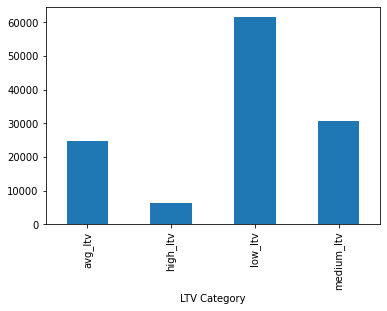

In [151]:
ltv_make_model_r.groupby('LTV Category').size().plot(kind='bar')

In [152]:
# Getting the number of fundings according to year
cnt_srs = ltv_make_model_r["LTV Category"].value_counts()
# sorting the years in ascending order
cnt_srs = cnt_srs.sort_index()
# setting uo the bar graph
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    
)
# setting the layout
layout = go.Layout(
    title=go.layout.Title(
        text="Customer LTV Catogarization",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="funding")

# machine Leraing

In [153]:
df2=ltv_make_model_r.copy()
df2

,Make,Model,City,Customer No.,Invoice No,Total_Expense,Job_duration(in hrs),LTV,LTV Category
3,AUDI,A4,East Godavari,182988,2,479.380000,12.500000,958.76,low_ltv
4,AUDI,A4,East Godavari,243916,1,1478.300000,4.000000,1478.30,low_ltv
6,AUDI,A4,Ghaziabad,141369,1,248.890000,1.000000,248.89,low_ltv
9,AUDI,A4,Khorda,259799,1,330.500000,0.000000,330.50,low_ltv
11,AUDI,A4,Malappuram,201655,1,151.340000,1.000000,151.34,low_ltv
...,...,...,...,...,...,...,...,...,...
132692,VOLKSWAGEN,VENTO,Tirunelveli,228476,3,11843.713333,210.666667,35531.14,high_ltv
132698,VOLKSWAGEN,VENTO,Tiruvallur,217891,3,27206.773333,215.333333,81620.32,high_ltv
132714,VOLKSWAGEN,VENTO,Udham Singh Nagar,195934,1,26041.370000,126.000000,26041.37,high_ltv
132728,VOLKSWAGEN,VENTO,Vadodara,256649,1,34422.020000,101.000000,34422.02,high_ltv


In [154]:
le=LabelEncoder()
df2["Make"]=le.fit_transform(df2["Make"])
df2["Model"]=le.fit_transform(df2["Model"])
df2["LTV Category"]=le.fit_transform(df2["LTV Category"])
df2["City"]=le.fit_transform(df2["City"])

In [155]:
X=df2.drop(["Customer No.","LTV","LTV Category","Invoice No"],1)
y=df2["LTV Category"]

In [156]:
X

,Make,Model,City,Total_Expense,Job_duration(in hrs)
3,0,8,116,479.380000,12.500000
4,0,8,116,1478.300000,4.000000
6,0,8,139,248.890000,1.000000
9,0,8,224,330.500000,0.000000
11,0,8,261,151.340000,1.000000
...,...,...,...,...,...
132692,26,210,409,11843.713333,210.666667
132698,26,210,410,27206.773333,215.333333
132714,26,210,417,26041.370000,126.000000
132728,26,210,424,34422.020000,101.000000


In [157]:
y

3         2
4         2
6         2
9         2
11        2
         ..
132692    1
132698    1
132714    1
132728    1
132740    1
Name: LTV Category, Length: 123133, dtype: int64

In [158]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

# Decision Tree Classifier

In [159]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8,random_state=0)

dt.fit(X_train,y_train)

y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      7369
           1       0.99      0.60      0.74      1859
           2       0.92      1.00      0.96     18444
           3       0.82      0.85      0.83      9268

    accuracy                           0.89     36940
   macro avg       0.90      0.80      0.84     36940
weighted avg       0.89      0.89      0.89     36940



In [160]:
print("Training Accuracy :-" , accuracy_score(y_test,y_pred_dt))
print("Testing Accuracy :-" ,accuracy_score(y_train,y_pred_dt_train))

Training Accuracy :- 0.8906876015159718
Testing Accuracy :- 0.8918821714060307


<BarContainer object of 5 artists>

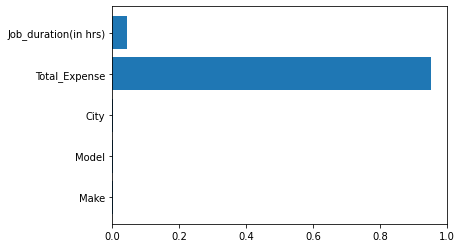

In [161]:
plt.barh(list(X),list(dt.feature_importances_))

# Random Forest Classifier


In [162]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=8,random_state=0)

In [163]:
rfc.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, random_state=0)

In [164]:
y_pred_rfc=rfc.predict(X_test)

In [165]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80      7369
           1       1.00      0.59      0.74      1859
           2       0.92      1.00      0.96     18444
           3       0.81      0.84      0.82      9268

    accuracy                           0.88     36940
   macro avg       0.90      0.79      0.83     36940
weighted avg       0.89      0.88      0.88     36940



In [166]:
accuracy_score(y_test,y_pred_rfc)

0.8848402815376286

<BarContainer object of 5 artists>

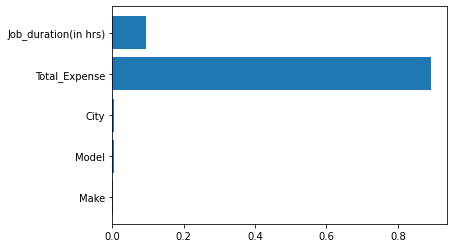

In [167]:
plt.barh(list(X),list(rfc.feature_importances_))

In [168]:
score=cross_val_score(estimator=rfc,X=X,y=y,cv=5)

In [169]:
score.mean()

0.8266819933345413

# XgBoost Classifier

In [170]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb=xgb.predict(X_test)
accuracy_score(y_test,y_pred_xgb)
print(classification_report(y_test,y_pred_xgb))


[15:37:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      7369
           1       0.96      0.64      0.77      1859
           2       0.94      1.00      0.97     18444
           3       0.84      0.88      0.86      9268

    accuracy                           0.91     36940
   macro avg       0.91      0.83      0.86     36940
weighted avg       0.91      0.91      0.91     36940



In [171]:
scores_xgb=cross_val_score(estimator=xgb,X=X,y=y,cv=5)
scores_xgb.mean()

[15:37:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:37:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

0.8406915199795156